<a href="https://colab.research.google.com/github/fausto1364/age-estimation/blob/main/age_estimation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [40]:
import os
import re
import csv
import numpy as np

# image manipulation
from PIL import Image

# deep learning
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data

Age estimation using AlexNet based architecture

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [2]:
# path to APA-REAL in drive
path='/content/drive/MyDrive/appa-real-release'

train_path = os.path.join(path, 'train')
test_path = os.path.join(path, 'test')
valid_path = os.path.join(path, 'valid')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
print(len(os.listdir(train_path))/3)
print(len(os.listdir(test_path))/3)
print(len(os.listdir(valid_path))/3)

1614.6666666666667
1990.6666666666667
1500.0


In [ ]:
# preprocessing: What needs to be done?

# adapt the size of the images?
# do the split in training, test, validation
# have the apparent age stored somehow

In [14]:
image = Image.open(os.path.join(path,'005612.jpg_face.jpg'))

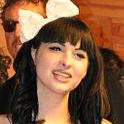

In [15]:
image.show()

In [16]:
print(image.format)
print(image.mode)
print(image.size)

JPEG
RGB
(124, 124)


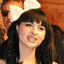

In [18]:
test = image.resize((64,64))
test.show()

In [63]:
def preprocess(folder_path,size):
  X=[]
  y=[]
  # regular expression pattern to only extract files with face detection
  pattern = r"\d+\.jpg_face\.jpg"

  # Loop over all files in the folder
  for imagename in os.listdir(folder_path):
    image_path = os.path.join(folder_path, imagename)
    
    if re.match(pattern, imagename):
      image = Image.open(image_path)
      image = image.resize(size)
      X.append(np.array(image.getdata()).reshape(image.size[1], image.size[0], 3))
      y.append(imagename.split(".")[0])
  return X,y

In [64]:
images_valid,y = preprocess(valid_path,(64,64)) # with these settings it took about 1 min runtime

In [66]:
# read the csv files with the apparent ages
def get_appaages(path):
  number = []
  apparent_age = []

  # Read the CSV file
  with open(path, "r") as csv_file:
    csv_reader = csv.reader(csv_file)
    
    # Skip header
    next(csv_reader)
    
    # Iterate over each row in the CSV file
    for row in csv_reader:
        # Append the values of the first and third columns to their respective lists
        number.append(row[0].split(".")[0])
        apparent_age.append(row[2])

  return apparent_age, number

In [67]:
gt_valid = os.path.join(path, 'gt_avg_valid.csv')
appaages_valid, number_valid = get_appaages(gt_valid)

'''
gt_test = os.path.join(path, 'gt_avg_test.csv')
appaages_test, number_test = get_age(gt_test)

gt_train = os.path.join(path, 'gt_avg_train.csv')
appaages_train, number_train = get_age(gt_train)
'''

"\ngt_test = os.path.join(path, 'gt_avg_test.csv')\nappaages_test, number_test = get_age(gt_test)\n\ngt_train = os.path.join(path, 'gt_avg_train.csv')\nappaages_train, number_train = get_age(gt_train)\n"

In [69]:
def allign_lists(A,a,B,b):
  X=[]
  Y=[]
  for i in range(len(A)):
    X.append(A[i])
    Y.append(float(B[b.index(a[i])]))

  return np.array(X),np.array(Y)

In [70]:
images_valid,appaages_valid=allign_lists(images_valid,y,appaages_valid,number_valid)

In [ ]:
#### do theses things need to be sorted? or how do images_train and appaages_train correspond? sorted?

# Convert data to PyTorch tensors
train_data = data.TensorDataset(torch.tensor(images_train), torch.tensor(appaages_train))
test_data = data.TensorDataset(torch.tensor(images_test), torch.tensor(appaages_test))
val_data = data.TensorDataset(torch.tensor(images_valid), torch.tensor(appaages_valid))

# Create dataloaders
batch_size = 32
train_dataloader = data.DataLoader(train_data, batch_size=batch_size, shuffle=True)
test_dataloader = data.DataLoader(test_data, batch_size=batch_size)
val_dataloader = data.DataLoader(val_data, batch_size=batch_size)

In [36]:
# do the architecture. Basic, simple one
class AgeEstimationCNN(nn.Module):
    def __init__(self):
        super(AgeEstimationCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1)
        self.relu = nn.ReLU()
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.fc1 = nn.Linear(16 * 32 * 32, 256)
        self.fc2 = nn.Linear(256, 1)

    def forward(self, x):
        x = self.pool(self.relu(self.conv1(x)))
        x = x.view(-1, 16 * 32 * 32)
        x = self.relu(self.fc1(x))
        x = self.fc2(x)
        return x

In [37]:
model = AgeEstimationCNN()

criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [ ]:
# do the training

In [ ]:
num_epochs = 10

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0

    for inputs, labels in train_dataloader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels.unsqueeze(1).float())
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    # Print average loss for each epoch
    print(f"Epoch {epoch+1}/{num_epochs} - Loss: {running_loss/len(train_dataloader):.4f}")

In [ ]:
# do the evaluation
model.eval()
total_loss = 0.0

with torch.no_grad():
    for inputs, labels in test_dataloader:
        outputs = model(inputs)
        loss = criterion(outputs, labels.unsqueeze(1).float())
        total_loss += loss.item()

    average_loss = total_loss / len(test_dataloader)
    print(f"Test Loss: {average_loss:.4f}")